In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import CompressedFisher

In [6]:

nKs = 100
ks = 10**np.linspace(-4,0,nKs)



In [14]:


def pk_theory(ks,params):
    a,ns,alpha= params
    return a+ns*ks+alpha*ks**.5

def generateSims(params,nSims=1):
    pk_mu = pk_theory(ks,params)
    return  pk_mu+np.random.randn(nSims,nKs)*np.sqrt(2)*pk_mu

def generateCovMat(params):
    pk_mu = pk_theory(ks,params)
    return np.diag(2*pk_mu**2)

def theoretical_derivs(params):
    pk_mu = pk_theory(ks,params)
    nParams = len(params)
    derivs_thry = np.zeros([nParams,nKs])
    derivs_thry[0] = np.ones(nKs)
    derivs_thry[1] = ks.copy()
    derivs_thry[2] = np.sqrt(ks)
    derivs_thry_covMat = np.zeros([nParams,nKs,nKs])
    for i in range(nParams):
        derivs_thry_covMat[i] = 4*np.diag(derivs_thry[i])*pk_mu
    return derivs_thry,derivs_thry_covMat


def generate_deriv_sims(paramter_names,params,deltaParams,nSims):
    #a,ns,alpha,beta, gamma     = params
    #d_a,d_ns,d_alpha,d_beta,d_gamma = deltaParams
    deriv_sims = {}
    state = np.random.get_state()
    for i,name in enumerate(paramter_names):
        derivs_ens = np.zeros([2,nSims,nKs])
        params_plus = np.array(params)
        params_plus[i]+=deltaParams[i]
        
        params_minus = np.array(params)
        params_minus[i]-=deltaParams[i]
          
        np.random.set_state(state)
        derivs_ens[0] = generateSims(params_minus,nSims)
        np.random.set_state(state)  
        derivs_ens[1] = generateSims(params_plus,nSims)
        deriv_sims[name] = derivs_ens
    return deriv_sims


In [15]:
def fisherTheory(params):
    derivs,derivs_covMat = theoretical_derivs(params)
    covMat = generateCovMat(params)
    nParams = len(params)
    fisher = np.zeros([nParams,nParams])
    for i in range(nParams):
        tmp_a = (np.linalg.solve(covMat,derivs_covMat[i]))
        for j in range(i+1):
            tmp_b = (np.linalg.solve(covMat,derivs_covMat[j]))
            tmp =  np.dot(derivs[i], np.linalg.solve(covMat,derivs[j]))
            tmp+= .5*np.trace(np.dot(tmp_a,tmp_b))
            fisher[i,j] = fisher[j,i] = tmp
    return fisher


In [16]:
params_fid = np.array([1,1,1.])
delta_params = np.array([.1,.1,.1,])
parameter_names = [r"$\alpha$", r"$\beta$", r"$\gamma$"]
dict_param_steps = {parameter_names[i]:delta_params[i] for i in range(len(params_fid))}

In [21]:
nSimsCovMat = 20000
nSims_deriv = 300

In [22]:

fisher_true = fisherTheory(params_fid)
print(fisher_true)

[[175.41970592   7.21981339  21.28027102]
 [  7.21981339   2.58493994   3.88768597]
 [ 21.28027102   3.88768597   7.21981339]]


In [23]:
compress_frac_split = 0.5

In [24]:
covmat_sims = generateSims(params_fid,nSimsCovMat)
dict_deriv_sims = generate_deriv_sims(parameter_names,params_fid,delta_params,nSims=nSims_deriv)


In [25]:
cFisher = CompressedFisher.gaussianFisher(parameter_names,nSims_deriv,include_deriv_covmat=True,deriv_spline_order=2)


In [26]:
cFisher.initailize_covmat(covmat_sims)
cFisher.initailize_mean(covmat_sims)
cFisher.initailize_deriv_sims(dic_deriv_sims=dict_deriv_sims,dict_param_steps=dict_param_steps)


In [27]:
cFisher.generate_deriv_sim_splits(compress_frac_split)

  

In [28]:
  
stnd_constraint    = cFisher.compute_fisher_forecast(parameter_names)
stnd_constraint_bias = cFisher.est_fisher_forecast_bias(parameter_names)


compressed_constraint = cFisher.compute_compressed_fisher_forecast(parameter_names)
compressed_constraint_bias = cFisher.est_compressed_fisher_forecast_bias(parameter_names)


combined_constraint = cFisher.compute_combined_fisher_forecast(parameter_names)
  

In [29]:
print(np.diag(stnd_constraint)**.5,np.diag(stnd_constraint_bias/stnd_constraint))
print(np.diag(compressed_constraint)**.5,np.diag(compressed_constraint_bias/compressed_constraint))
print(np.diag(combined_constraint)**.5)
print(np.diag(np.linalg.inv(fisher_true))**.5)


[0.09677426 1.50470023 1.06460152] [0.24736488 0.20662218 0.21237229]
[0.13267178 1.9754265  1.38248325] [0.00595608 0.00458369 0.00460393]
[0.11307502 1.72396989 1.21309323]


In [30]:
      
std_nsim, std_mns,std_stds = cFisher.run_fisher_deriv_stablity_test(parameter_names,)

comp_nsim, comp_mns,comp_stds = cFisher.run_compressed_fisher_deriv_stablity_test(parameter_names,compress_frac_split)
geom_nsim, geom_mns,geom_stds = cFisher.run_combined_fisher_deriv_stablity_test(parameter_names,compress_frac_split)


30.0 
 [0.06885094 1.11661237 0.78090149] 
 [0.0095193  0.15224346 0.10016231]
60.0 
 [0.08432851 1.33853698 0.93525833] 
 [0.01171132 0.18475527 0.13098208]
100.0 
 [0.09259461 1.45383354 1.02769777] 
 [0.01222272 0.1953571  0.11897196]
120.0 
 [0.09470302 1.4765519  1.04023043] 
 [0.0088487  0.30357443 0.16155344]
150.0 
 [0.09733408 1.52939046 1.07404515] 
 [0.01432821 0.29981204 0.18710356]
300.0 
 [0.104528   1.61763075 1.13709585] 
 [0. 0. 0.]
30.0 
 [0.25929096 3.54733468 2.58159798] 
 [0.07771436 0.99625875 0.5934303 ]
60.0 
 [0.18804001 2.77117163 1.88429682] 
 [0.03168164 0.37362971 0.36313045]
100.0 
 [0.16751989 2.38469813 1.64813622] 
 [0.02528462 0.21247888 0.32615605]
120.0 
 [0.15602235 2.31439488 1.61272544] 
 [0.02562668 0.48437668 0.13269606]
150.0 
 [0.14627429 2.21027226 1.52787615] 
 [0.01565237 0.38768233 0.26356027]
300.0 
 [0.13312442 2.02146687 1.39830637] 
 [0. 0. 0.]
30.0 
 [0.11504086 1.71996147 1.23139905] 
 [0.02282568 0.34519708 0.22653767]
60.0 
 [0.113

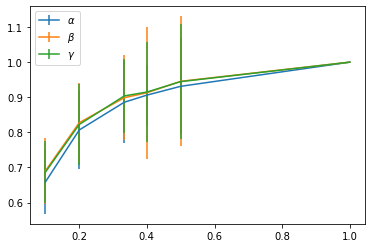

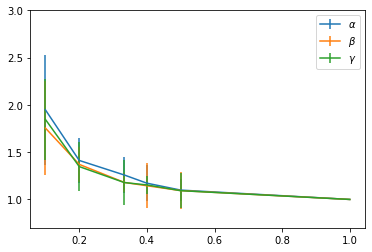

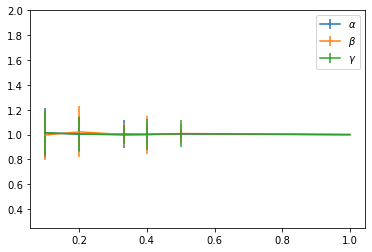

In [32]:

for i,p in enumerate(parameter_names):
    plt.errorbar(std_nsim/std_nsim[-1],std_mns[:,i,i]**.5/std_mns[-1,i,i]**.5,yerr=std_stds[:,i,i]**.5/std_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')

plt.legend()
plt.show()

for i,p in enumerate(parameter_names):
    plt.errorbar(comp_nsim/comp_nsim[-1],comp_mns[:,i,i]**.5/comp_mns[-1,i,i]**.5,yerr=comp_stds[:,i,i]**.5/comp_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')

plt.legend()
plt.ylim([.7,3])
plt.show()

for i,p in enumerate(parameter_names):
    plt.errorbar(geom_nsim/geom_nsim[-1],geom_mns[:,i,i]**.5/geom_mns[-1,i,i]**.5,yerr=geom_stds[:,i,i]**.5/geom_mns[-1,i,i]**.5,label=parameter_names[i])
#plt.plot(geom_nsim/geom_nsim[-1],(geom_nsim/geom_nsim[-1])**.5,scaley=False,color='k',alpha=.5,linestyle=':')
plt.legend()
plt.ylim([.25,2])
plt.show()
#plt.yscale('log')
#plt.yscale('log')

In [ ]:

stnd_fisher     = cFisher._compute_fisher_matrix(parameter_names)
stnd_fisher_err     = cFisher._compute_fisher_matrix_error(parameter_names)


compressed_fisher  = cFisher._compute_compressed_fisher_matrix(parameter_names)
compressed_fisher_err  = cFisher._compute_compressed_fisher_matrix_error(parameter_names)


combined_fisher = cFisher._compute_combined_fisher_matrix(parameter_names)